<a href="https://colab.research.google.com/github/Arzuki-zheng/border-collie-classifier/blob/main/notebooks/border_collie_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import kagglehub
from pathlib import Path
import shutil

# 1. 下載資料集
root = Path(kagglehub.dataset_download("amandam1/120-dog-breeds-breed-classification"))
images_dir = root / "Images"
print("資料集根目錄:", root)
print("Images 目錄:", images_dir)

# 2. 我們要整理成兩類：border_collie / other_dog
base_dir = Path("/content/dog_dataset")
border_dir = base_dir / "border_collie"
other_dir = base_dir / "other_dog"
border_dir.mkdir(parents=True, exist_ok=True)
other_dir.mkdir(parents=True, exist_ok=True)

border_folder_name = "n02106166-Border_collie"

# 3. 複製邊境牧羊犬圖片
src_border = images_dir / border_folder_name
for f in src_border.glob("*.jpg"):
    shutil.copy(f, border_dir / f.name)

# 4. 其餘全部視為「其他狗」
for class_dir in images_dir.iterdir():
    if not class_dir.is_dir():
        continue
    if class_dir.name == border_folder_name:
        continue
    for f in class_dir.glob("*.jpg"):
        # 在檔名前面加類別名稱，避免不同類別同名檔案覆蓋
        new_name = f"{class_dir.name}_{f.name}"
        shutil.copy(f, other_dir / new_name)

print("整理完成！")
print("邊境牧羊犬張數:", len(list(border_dir.glob('*.jpg'))))
print("其他狗張數:", len(list(other_dir.glob('*.jpg'))))
print("最終資料夾:", base_dir)


Using Colab cache for faster access to the '120-dog-breeds-breed-classification' dataset.
資料集根目錄: /kaggle/input/120-dog-breeds-breed-classification
Images 目錄: /kaggle/input/120-dog-breeds-breed-classification/Images
整理完成！
邊境牧羊犬張數: 150
其他狗張數: 20430
最終資料夾: /content/dog_dataset


In [6]:
from pathlib import Path
import random

other = Path("/content/dog_dataset/other_dog")
files = list(other.glob("*.jpg"))
random.shuffle(files)
for f in files[1500:]:
    f.unlink()
print("保留 other_dog：", len(list(other.glob('*.jpg'))))


保留 other_dog： 1500


In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pathlib import Path

data_root = Path("/content/dog_dataset")
img_size = (224,224); batch_size = 32

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = datagen.flow_from_directory(
    data_root, target_size=img_size, batch_size=batch_size,
    class_mode="binary", subset="training")

val_gen = datagen.flow_from_directory(
    data_root, target_size=img_size, batch_size=batch_size,
    class_mode="binary", subset="validation")

print("類別對應:", train_gen.class_indices)


Found 1320 images belonging to 2 classes.
Found 330 images belonging to 2 classes.
類別對應: {'border_collie': 0, 'other_dog': 1}


In [8]:
import tensorflow as tf
base = tf.keras.applications.MobileNetV2(input_shape=(224,224,3), include_top=False, weights='imagenet')
base.trainable = False
inputs = tf.keras.Input((224,224,3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
x = base(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [9]:
history = model.fit(train_gen, validation_data=val_gen, epochs=5)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.8132 - loss: 0.4430 - val_accuracy: 0.9091 - val_loss: 0.3054
Epoch 2/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.9068 - loss: 0.3219 - val_accuracy: 0.9091 - val_loss: 0.3063
Epoch 3/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - accuracy: 0.9099 - loss: 0.3126 - val_accuracy: 0.9091 - val_loss: 0.3043
Epoch 4/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.8966 - loss: 0.3367 - val_accuracy: 0.9091 - val_loss: 0.3046
Epoch 5/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.9111 - loss: 0.3113 - val_accuracy: 0.9091 - val_loss: 0.3035


In [10]:
save_path = "/content/border_collie_model.h5"
model.save(save_path)
print("模型已儲存：", save_path)


模型已儲存： /content/border_collie_model.h5


In [11]:
!mkdir -p /content/repo
%cd /content/repo
!git clone https://github.com/Arzuki-zheng/border-collie-classifier.git .
!cp /content/border_collie_model.h5 models/border_collie_model.h5
!git config user.email "lgm89703@gmail.com"
!git config user.name "Arzuki-zheng"
!git add models/border_collie_model.h5
!git commit -m "Add trained border collie model"
!git push


/content/repo
Cloning into '.'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 15 (delta 2), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (15/15), 4.35 KiB | 4.35 MiB/s, done.
Resolving deltas: 100% (2/2), done.
[main bc66b62] Add trained border collie model
 1 file changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 models/border_collie_model.h5
fatal: could not read Username for 'https://github.com': No such device or address


In [12]:
# 重新用新版格式儲存（建議 .keras）
model_save_dir = "/content/border_collie_model.keras"
model.save(model_save_dir)   # 不加 save_format，會自動存成 .keras zip 格式
print("新模型已儲存：", model_save_dir)


新模型已儲存： /content/border_collie_model.keras


In [13]:
base.trainable = True
for layer in base.layers[:-40]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='binary_crossentropy', metrics=['AUC','Precision','Recall','Accuracy'])
history2 = model.fit(train_gen, validation_data=val_gen, epochs=5,
                     class_weight={0:1.0, 1:max(1.0, len(train_gen.classes[train_gen.classes==0])/
                                          len(train_gen.classes[train_gen.classes==1]))})


Epoch 1/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 124s 3s/step - AUC: 0.5950 - Accuracy: 0.9096 - Precision: 0.9096 - Recall: 1.0000 - loss: 0.3185 - val_AUC: 0.5724 - val_Accuracy: 0.9091 - val_Precision: 0.9091 - val_Recall: 1.0000 - val_loss: 0.3034
Epoch 2/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - AUC: 0.8363 - Accuracy: 0.9196 - Precision: 0.9195 - Recall: 1.0000 - loss: 0.2279 - val_AUC: 0.5888 - val_Accuracy: 0.9091 - val_Precision: 0.9091 - val_Recall: 1.0000 - val_loss: 0.3039
Epoch 3/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - AUC: 0.8794 - Accuracy: 0.9076 - Precision: 0.9072 - Recall: 0.9994 - loss: 0.2366 - val_AUC: 0.5665 - val_Accuracy: 0.9091 - val_Precision: 0.9091 - val_Recall: 1.0000 - val_loss: 0.3044
Epoch 4/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - AUC: 0.9096 - Accuracy: 0.9180 - Precision: 0.9180 - Recall: 0.9996 - loss: 0.1987 - val_AUC: 0.6015 - val_Accuracy: 0.9091 - val_Precision: 0.9091 - val_Recall: 1.0000 - val_loss: 0.3026
Epoch 5/5
42/42 ━━━━━━━━━━━━━━━━━━━━ 98s 2

In [14]:
from pathlib import Path
import random

border_dir = Path("/content/dog_dataset/border_collie")
other_dir = Path("/content/dog_dataset/other_dog")

print("目前 border_collie：", len(list(border_dir.glob("*.jpg"))))
print("目前 other_dog：", len(list(other_dir.glob("*.jpg"))))

target_other = 450  # 你可以改 300 或 600 試試
files = list(other_dir.glob("*.jpg"))
random.shuffle(files)

# 先全部清空，再重新挑 target_other 張
for f in files:
    f.unlink()

# 這裡示範：假設你「原始 Images 資料夾」還在，可以再從那邊抽新圖進來
images_dir = Path("/kaggle/input/120-dog-breeds-breed-classification/Images")
border_folder_name = "n02106166-Border_collie"

other_files_pool = []
for class_dir in images_dir.iterdir():
    if not class_dir.is_dir():
        continue
    if class_dir.name == border_folder_name:
        continue
    other_files_pool.extend(list(class_dir.glob("*.jpg")))

random.shuffle(other_files_pool)
for f in other_files_pool[:target_other]:
    new_name = f"{f.parent.name}_{f.name}"
    shutil.copy(f, other_dir / new_name)

print("重新抽樣後 other_dog：", len(list(other_dir.glob('*.jpg'))))


目前 border_collie： 150
目前 other_dog： 1500
重新抽樣後 other_dog： 450


In [15]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    "/content/dog_dataset",
    target_size=(224,224),
    batch_size=32,
    class_mode="binary",
    subset="training"
)

val_gen = datagen.flow_from_directory(
    "/content/dog_dataset",
    target_size=(224,224),
    batch_size=32,
    class_mode="binary",
    subset="validation"
)

print("類別對應:", train_gen.class_indices)
print("訓練張數:", train_gen.samples, "驗證張數:", val_gen.samples)


Found 480 images belonging to 2 classes.
Found 120 images belonging to 2 classes.
類別對應: {'border_collie': 0, 'other_dog': 1}
訓練張數: 480 驗證張數: 120


In [17]:
datagen = ImageDataGenerator(
  rescale=1./255, validation_split=0.2,
  rotation_range=20, width_shift_range=0.1, height_shift_range=0.1,
  shear_range=0.1, zoom_range=0.2, horizontal_flip=True
)


In [18]:
from sklearn.metrics import roc_curve
p = model.predict(val_gen).ravel()
fpr,tpr,thr = roc_curve(val_gen.classes, p)
best = thr[(tpr-fpr).argmax()]


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step


In [19]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# 取得驗證集真實標籤與預測
val_gen.reset()
probs = model.predict(val_gen).ravel()
y_true = val_gen.classes
y_pred = (probs >= 0.5).astype(int)  # 先用 0.5 當閾值

print("混淆矩陣 (rows=true, cols=pred):")
print(confusion_matrix(y_true, y_pred))
print()
print("分類報告：")
print(classification_report(y_true, y_pred, target_names=["border_collie","other_dog"]))


4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step
混淆矩陣 (rows=true, cols=pred):
[[ 0 30]
 [ 0 90]]

分類報告：
               precision    recall  f1-score   support

border_collie       0.00      0.00      0.00        30
    other_dog       0.75      1.00      0.86        90

     accuracy                           0.75       120
    macro avg       0.38      0.50      0.43       120
 weighted avg       0.56      0.75      0.64       120



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


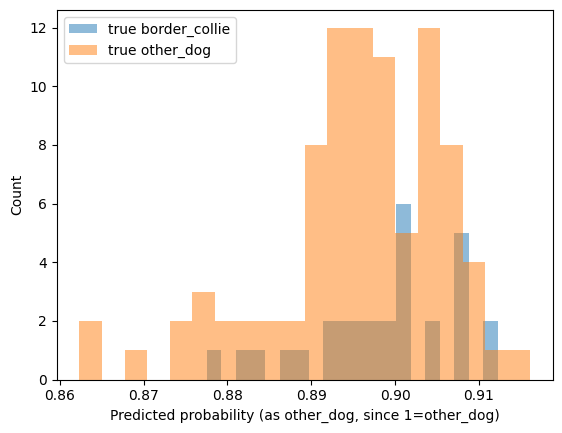

In [20]:
import matplotlib.pyplot as plt

# probs 是 model.predict(val_gen).ravel() 得到的機率
plt.hist(probs[y_true == 0], bins=20, alpha=0.5, label="true border_collie")
plt.hist(probs[y_true == 1], bins=20, alpha=0.5, label="true other_dog")
plt.legend()
plt.xlabel("Predicted probability (as other_dog, since 1=other_dog)")
plt.ylabel("Count")
plt.show()
